<a href="https://colab.research.google.com/github/IvanKatorgin/Recommender-systems/blob/main/%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Рекомендательные системы". Домашнее задание 1. Рекомендации на основе содержания. Каторгин И.П.

## Описание задания

1. Использовать датасет MovieLens https://grouplens.org/datasets/movielens/latest/.
2. Построить рекомендации (регрессия, предсказываем оценку) на фичах:
- TF-IDF на тегах и жанрах;
- средние оценки (+ median, variance и т. д.) пользователя и фильма.
3. Оценить RMSE на тестовой выборке.

Поскольку, при работе с основным датасетом (ml-latest.zip (size: 335 MB)) каждый раз при попытке добавления таблицы с тегами к таблице с фильмами и рейтингами сеанс прерывался и выдавалось сообщение “Сеанс прекращен, так как объем ОЗУ полностью исчерпан”, было принято решение домашнее задание выполнять на учеченной выборке из файла ml-latest-small.zip (size: 1 MB)

In [1]:
# загрузим датасет MovieLens с сайта https://grouplens.org/datasets/movielens/

!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-11-28 16:55:01--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.32MB/s    in 0.2s    

2024-11-28 16:55:02 (4.32 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [300]:
# импортируем библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm_notebook

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [301]:
# прочитаем файл README.txt и выведем его содержимое
with open('ml-latest-small/README.txt') as f:
    print(f.read())

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

In [302]:
# прочитаем файлы
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
#genome_scores = pd.read_csv('ml-latest/genome-scores.csv')
#genome_tags = pd.read_csv('ml-latest/genome-tags.csv')

In [303]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [304]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [305]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [306]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
#genome_scores.head()

In [ ]:
#genome_tags.head()

In [307]:
# соединим таблицу с рейтингами и названиями фильмов
joined_ratings = ratings.join(movies.set_index('movieId'), on='movieId')

In [308]:
joined_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


<Axes: >

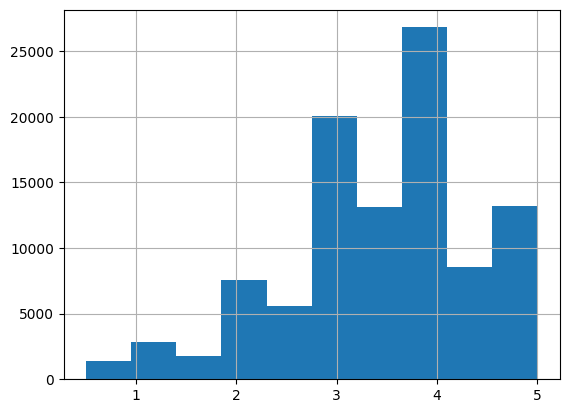

In [309]:
# посмотрим на гистограмму распределения оценок
joined_ratings.rating.hist()

<Axes: >

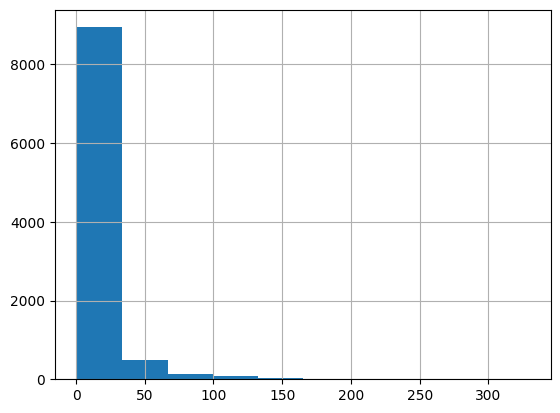

In [310]:
# гистограмма по количеству оценок на фильм
joined_ratings.groupby('title').rating.count().hist()

In [311]:
#  преобразуем значение даты
joined_ratings['dt'] = joined_ratings['timestamp'].apply(lambda t: datetime.fromtimestamp(t))

In [312]:
joined_ratings['year'] = joined_ratings['dt'].dt.year

In [313]:
joined_ratings['month'] = joined_ratings['dt'].dt.month

In [47]:
#joined_ratings['day'] = joined_ratings['dt'].dt.day

In [48]:
#joined_ratings['year_month'] = joined_ratings['year'].astype(str) + '-' + joined_ratings['month'].astype(str)

In [314]:
joined_ratings.drop(['timestamp', 'dt'],axis= 1 , inplace= True )

In [315]:
joined_ratings.head()

,userId,movieId,rating,title,genres,year,month
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,2000,7
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2000,7
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,2000,7


In [316]:
# добавим таблицу с тегами
joined_ratings_tags = joined_ratings.join(tags.set_index('movieId'), on='movieId', lsuffix='_left', rsuffix='_right')
joined_ratings_tags

,userId_left,movieId,rating,title,genres,year,month,userId_right,tag,timestamp
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,336.0,pixar,1.139046e+09
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,474.0,pixar,1.137207e+09
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,567.0,fun,1.525286e+09
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,289.0,moldy,1.143425e+09
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,289.0,old,1.143425e+09
...,...,...,...,...,...,...,...,...,...,...
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,567.0,emotional,1.525284e+09
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,567.0,gritty,1.525284e+09
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,567.0,heartbreaking,1.525284e+09
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,567.0,predictible plot,1.525284e+09


In [317]:
# удалим ненужные столбцы
joined_ratings_tags.drop(['userId_right', 'timestamp'],axis= 1 , inplace= True )
joined_ratings_tags.head()

,userId_left,movieId,rating,title,genres,year,month,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,fun
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,moldy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,old


In [318]:
# переименуем столбец userId_left в userId
joined_ratings_tags = joined_ratings_tags.rename(columns={'userId_left':'userId'})
joined_ratings_tags

,userId,movieId,rating,title,genres,year,month,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,fun
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,moldy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,old
...,...,...,...,...,...,...,...,...
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,emotional
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,gritty
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,heartbreaking
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,predictible plot


Добавим новые фичи по фильмам

In [319]:
# средний рейтинг фильма
films_mean_rating = joined_ratings_tags.groupby('movieId')[['rating']].mean().sort_values('rating', ascending=False)
films_mean_rating = films_mean_rating.rename(columns={'rating':'mean_rating'})
films_mean_rating

,mean_rating
movieId,
88448,5.0
100556,5.0
143031,5.0
143511,5.0
143559,5.0
...,...
157172,0.5
85334,0.5
53453,0.5


In [320]:
# медианнная оценка фильма
films_median_rating = joined_ratings_tags.groupby('movieId')[['rating']].median().sort_values('rating', ascending=False)
films_median_rating  = films_median_rating.rename(columns={'rating':'median_rating'})
films_median_rating

,median_rating
movieId,
3942,5.0
147250,5.0
115122,5.0
86237,5.0
1151,5.0
...,...
125916,0.5
54934,0.5
97024,0.5


In [321]:
# создадим словарь фильмов с кол-вом рейтингов
movieId_num_ratings = {}

for movieId, group in tqdm_notebook(joined_ratings_tags.groupby('movieId')):
  movieId_num_ratings[movieId] = group.userId.unique().shape[0]

([(movieId_num_ratings[x], x ) for x in movieId_num_ratings])[:5]

  0%|          | 0/9724 [00:00<?, ?it/s]

[(215, 1), (110, 2), (52, 3), (7, 4), (49, 5)]

In [322]:
# статистики по количеству рейтингов фильма
min_num_ratings = np.min([movieId_num_ratings[f] for f in movieId_num_ratings.keys()])
max_num_ratings = np.max([movieId_num_ratings[f] for f in movieId_num_ratings.keys()])
mean_num_ratings = np.mean([movieId_num_ratings[f] for f in movieId_num_ratings.keys()])
median_num_ratings = np.median([movieId_num_ratings[f] for f in movieId_num_ratings.keys()])

print(min_num_ratings)
print(max_num_ratings)
print(mean_num_ratings)
print(median_num_ratings)

# средний рейтинг на каждый фильм
movieId_mean_rating = {}

for movieId, group in tqdm_notebook(joined_ratings_tags.groupby('movieId')):
  movieId_mean_rating[movieId] = group.rating.mean()

1
329
10.369806663924312
3.0


  0%|          | 0/9724 [00:00<?, ?it/s]

In [323]:
# средневзвешенная оценка фильма

film_with_our_mark = []

for f in movieId_num_ratings.keys():
  film_with_our_mark.append((f, movieId_mean_rating[f] * (movieId_num_ratings[f] - mean_num_ratings) / (max_num_ratings - min_num_ratings)))

In [324]:
# выводим топ 10 фильмов
list(sorted(film_with_our_mark, key=lambda x: x[1], reverse=True))[:10]
suspended_rating_films = pd.DataFrame(film_with_our_mark, columns=['movieId', 'suspended_rating'])

In [325]:
# добавим к исходной таблице новые признаки:

# среднее значение рейтинга фильма
joined_ratings_tags = joined_ratings_tags.merge(films_mean_rating, left_on = 'movieId', right_on='movieId', how = 'left' )

# медианное значение рейтинга фильма
joined_ratings_tags = joined_ratings_tags.merge(films_median_rating, left_on = 'movieId', right_on='movieId', how = 'left' )

# средневзыешенное значение рейтинга фильма
joined_ratings_tags =joined_ratings_tags.merge(suspended_rating_films, left_on = 'movieId', right_on='movieId', how = 'left' )

joined_ratings_tags

,userId,movieId,rating,title,genres,year,month,tag,mean_rating,median_rating,suspended_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar,3.920930,4.0,2.446161
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar,3.920930,4.0,2.446161
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,fun,3.920930,4.0,2.446161
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,moldy,3.259615,3.0,0.413715
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,old,3.259615,3.0,0.413715
...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,emotional,4.280000,4.5,0.190906
285758,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,gritty,4.280000,4.5,0.190906
285759,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,heartbreaking,4.280000,4.5,0.190906
285760,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,predictible plot,4.280000,4.5,0.190906


Сделаем тоже самое с пользователями

In [326]:
# средний рейтинг пользователя
user_mean_rating = joined_ratings_tags.groupby('userId')[['rating']].mean().sort_values('rating', ascending=False)
user_mean_rating = user_mean_rating.rename(columns={'rating':'user_mean_rating'})
user_mean_rating

,user_mean_rating
userId,
53,5.000000
251,4.969027
515,4.957711
348,4.907658
25,4.905028
...,...
308,2.015888
3,1.980392
126,1.821168


In [327]:
# медианнная оценка пользователя
user_median_rating = joined_ratings_tags.groupby('userId')[['rating']].median().sort_values('rating', ascending=False)
user_median_rating  = user_median_rating.rename(columns={'rating':'user_median_rating'})
user_median_rating

,user_median_rating
userId,
164,5.0
102,5.0
529,5.0
96,5.0
97,5.0
...,...
308,1.0
126,1.0
173,1.0


In [328]:
# создадим словарь user с кол-вом рейтингов usera
userId_num_ratings = {}

for userId, group in tqdm_notebook(joined_ratings_tags.groupby('userId')):
  userId_num_ratings[userId] = group.movieId.count()

([(userId_num_ratings[x], x ) for x in userId_num_ratings])[:5]

  0%|          | 0/610 [00:00<?, ?it/s]

[(711, 1), (152, 2), (51, 3), (674, 4), (283, 5)]

In [329]:
# статистики по количеству рейтингов usera
min_user_ratings = np.min([userId_num_ratings[f] for f in userId_num_ratings.keys()])
max_user_ratings = np.max([userId_num_ratings[f] for f in userId_num_ratings.keys()])
mean_user_ratings = np.mean([userId_num_ratings[f] for f in userId_num_ratings.keys()])
median_user_ratings = np.median([userId_num_ratings[f] for f in userId_num_ratings.keys()])

print(min_user_ratings)
print(max_user_ratings)
print(mean_user_ratings)
print(median_user_ratings)

# средний рейтинг на каждого usera
userId_mean_rating = {}

for userId, group in tqdm_notebook(joined_ratings_tags.groupby('userId')):
  userId_mean_rating[userId] = group.rating.mean()

21
4214
468.4622950819672
319.5


  0%|          | 0/610 [00:00<?, ?it/s]

In [330]:
# средневзвешенная оценка пользователя
user_with_our_mark = []

for f in userId_num_ratings.keys():
  user_with_our_mark.append((f, userId_mean_rating[f] * (userId_num_ratings[f] - mean_user_ratings) / (max_user_ratings - min_user_ratings)))

In [331]:
# выводим топ 10 пользователей
list(sorted(user_with_our_mark, key=lambda x: x[1], reverse=True))[:10]
suspended_rating_users = pd.DataFrame(user_with_our_mark, columns=['userId', 'user_suspended_rating'])

In [332]:
# добавим к исходной таблице новые признаки:

# среднее значение рейтинга пользователя
joined_ratings_tags = joined_ratings_tags.merge(user_mean_rating, left_on = 'userId', right_on='userId', how = 'left' )

# медианное значение рейтинга пользователя
joined_ratings_tags = joined_ratings_tags.merge(user_median_rating, left_on = 'userId', right_on='userId', how = 'left' )

# средневзыешенное значение рейтинга пользователя
joined_ratings_tags =joined_ratings_tags.merge(suspended_rating_users, left_on = 'userId', right_on='userId', how = 'left' )

joined_ratings_tags

,userId,movieId,rating,title,genres,year,month,tag,mean_rating,median_rating,suspended_rating,user_mean_rating,user_median_rating,user_suspended_rating
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar,3.920930,4.0,2.446161,4.088608,4.0,0.236499
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,pixar,3.920930,4.0,2.446161,4.088608,4.0,0.236499
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000,7,fun,3.920930,4.0,2.446161,4.088608,4.0,0.236499
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,moldy,3.259615,3.0,0.413715,4.088608,4.0,0.236499
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2000,7,old,3.259615,3.0,0.413715,4.088608,4.0,0.236499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,emotional,4.280000,4.5,0.190906,4.038214,4.0,2.094264
285758,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,gritty,4.280000,4.5,0.190906,4.038214,4.0,2.094264
285759,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,heartbreaking,4.280000,4.5,0.190906,4.038214,4.0,2.094264
285760,610,168252,5.0,Logan (2017),Action|Sci-Fi,2017,5,predictible plot,4.280000,4.5,0.190906,4.038214,4.0,2.094264


In [333]:
#  преобразуем жанр фильма в векторы

def change_string(s):
  return ' '.join(s.replace(' ', '').replace('-', '').split('|'))


film_genres = [change_string(g) for g in joined_ratings_tags.genres.values]

tfidf = TfidfVectorizer()
film_tfidf = tfidf.fit_transform(film_genres)
# film_tfidf

df_film_tfidf = pd.DataFrame(film_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_film_tfidf

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,horror,imax,musical,mystery,nogenreslisted,romance,scifi,thriller,war,western
0,0.000000,0.348743,0.548508,0.527195,0.255409,0.000000,0.0,0.000000,0.484096,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.348743,0.548508,0.527195,0.255409,0.000000,0.0,0.000000,0.484096,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.348743,0.548508,0.527195,0.255409,0.000000,0.0,0.000000,0.484096,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.512716,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.858558,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.512716,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.858558,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,0.651005,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.759073,0.000000,0.0,0.0
285758,0.651005,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.759073,0.000000,0.0,0.0
285759,0.651005,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.759073,0.000000,0.0,0.0
285760,0.651005,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.759073,0.000000,0.0,0.0


In [334]:
#  преобразуем теги фильма в векторы

def change_string(s):
  return str(s).replace(' ', '').replace('-', '').lower()

tag_films = []
film = []

for movieId, group in tqdm_notebook( joined_ratings_tags.groupby('movieId')):

    tag_films.append(' '.join([change_string(s) for s in group.tag.values]))
    film.append(movieId)

tfidf_tag = TfidfVectorizer()
tag_tfidf = tfidf.fit_transform(tag_films)
# # film_tfidf

df_tag_tfidf = pd.DataFrame(tag_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_tag_tfidf.head()

  0%|          | 0/9724 [00:00<?, ?it/s]

,06oscarnominatedbestmovieanimation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001like,2danimation,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [335]:
# добавим новые признаки в датасет
df = joined_ratings_tags.loc[:, ~joined_ratings_tags.columns.isin(['title', 'genres', 'tag'])]

df = pd.merge(df, df_film_tfidf, left_index=True, right_index=True)

df = pd.merge(df, df_tag_tfidf, left_index=True, right_index=True)

df

,userId,movieId,rating,year,month,mean_rating,median_rating,suspended_rating,user_mean_rating,user_median_rating,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,1,1,4.0,2000,7,3.920930,4.0,2.446161,4.088608,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,4.0,2000,7,3.920930,4.0,2.446161,4.088608,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,4.0,2000,7,3.920930,4.0,2.446161,4.088608,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3,4.0,2000,7,3.259615,3.0,0.413715,4.088608,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3,4.0,2000,7,3.259615,3.0,0.413715,4.088608,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,21,356,4.5,2014,8,4.164134,4.0,4.045179,3.258284,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,21,356,4.5,2014,8,4.164134,4.0,4.045179,3.258284,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,21,364,4.0,2014,12,3.941860,4.0,1.942450,3.258284,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,21,364,4.0,2014,12,3.941860,4.0,1.942450,3.258284,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [336]:
# построим модель линейной регрессии

X = df.loc[:, df.columns != 'rating']
y = df.rating

In [337]:
X

,userId,movieId,year,month,mean_rating,median_rating,suspended_rating,user_mean_rating,user_median_rating,user_suspended_rating,...,worldwari,worldwarii,writing,wrongfulimprisonment,wry,youngermen,zither,zoekazan,zombies,zooeydeschanel
0,1,1,2000,7,3.920930,4.0,2.446161,4.088608,4.0,0.236499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2000,7,3.920930,4.0,2.446161,4.088608,4.0,0.236499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,2000,7,3.920930,4.0,2.446161,4.088608,4.0,0.236499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,3,2000,7,3.259615,3.0,0.413715,4.088608,4.0,0.236499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,3,2000,7,3.259615,3.0,0.413715,4.088608,4.0,0.236499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,21,356,2014,8,4.164134,4.0,4.045179,3.258284,3.5,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,21,356,2014,8,4.164134,4.0,4.045179,3.258284,3.5,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,21,364,2014,12,3.941860,4.0,1.942450,3.258284,3.5,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,21,364,2014,12,3.941860,4.0,1.942450,3.258284,3.5,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
y

,rating
0,4.0
1,4.0
2,4.0
3,4.0
4,4.0
...,...
9719,4.5
9720,4.5
9721,4.0
9722,4.0


In [339]:
# разделим выборку на тренировочную и тестовую
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [340]:
model = LinearRegression()
model.fit(x_train, y_train)
model.predict(x_test)

array([ 3.88979859e+00,  2.28715521e+00,  4.21766914e+00, ...,
        2.41067980e+00,  3.15541422e+00, -1.09328166e+05])

In [342]:
# оценим качество модели
print(f'Среднеквадратическая ошибка (MSE Train): {mean_squared_error(y_train, model.predict(x_train))}')
print(f'Среднеквадратическая ошибка (MSE Test): {mean_squared_error(y_test, model.predict(x_test))}')
print(f'RMSE Train: {mean_squared_error(y_train, model.predict(x_train), squared = False)}')
print(f'RMSE Test: {mean_squared_error(y_test, model.predict(x_test), squared = False)}')
print(f'Среднее абсолютное отклонение (MAE Train): {mean_absolute_error(y_train, model.predict(x_train))}')
print(f'Среднее абсолютное отклонение (MAE Test): {mean_absolute_error(y_test, model.predict(x_test))}')

Среднеквадратическая ошибка (MSE Train): 0.6908166414327186
Среднеквадратическая ошибка (MSE Test): 224818010641.00302
RMSE Train: 0.8311538013103944
RMSE Test: 474149.7765906919
Среднее абсолютное отклонение (MAE Train): 0.6325792914052063
Среднее абсолютное отклонение (MAE Test): 27283.05102164386


Выводы:
1. Построена модель линейной регрессии рекомендации на фичах:
- TF-IDF на тегах и жанрах;
- средних оценках пользователей и фильмов.
2. Оценена RMSE на тестовой выборке.